In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pyotc.utils import *

# Helper function to generate point cloud
def get_pointcloud(mean_sigma, block_size, n_blocks, dim):
    point_sigma = 1
    means = np.random.normal(0, mean_sigma, (n_blocks, dim))
    points = np.zeros((block_size * n_blocks, dim))
    for c in range(n_blocks):
        for dim_idx in range(dim):
            points[c * block_size: (c + 1) * block_size, dim_idx] = np.random.normal(means[c, dim_idx], point_sigma, block_size)
    return points, means

block_size = 2;
n_blocks = 2;
n = block_size*n_blocks;
dim = 2;

mean_sigma = 5  # Example value

# Generate point clouds V1 and V2
V1, V2 = get_pointcloud(mean_sigma, block_size, n_blocks, dim)



# Generate random matrix A2
A2 = np.random.randint(1, 11, (n_blocks, n_blocks))

# Generate matrix A1
A1 = np.zeros((n, n))
for i in range(n_blocks):
    for j in range(n_blocks):
        for k in range(block_size):
            rv = np.random.rand(block_size)
            rv = rv * A2[i, j] / np.sum(rv) / block_size
            A1[i * block_size + k, j * block_size: (j + 1) * block_size] = rv


P1 = A1 / np.sum(A1, axis=1)[:, np.newaxis]
P2 = A2 / np.sum(A2, axis=1)[:, np.newaxis]

c = np.zeros((n, n_blocks)) # checked

for i in range(n):
    for j in range(n_blocks):
        c[i, j] = np.sum((V1[i, :] - V2[j, :]) ** 2)

cost, otc_edge_alignment, otc_alignment = exact_otc(P1, P2, c)
print(f"cost: {cost}")
otc_alignment[np.where(otc_alignment < 1e-4)] = 0

print(otc_alignment.shape)
aligned_mass_otc = eval_alignment(otc_alignment, block_size, n_blocks)
# aligned_mass_fgw = eval_alignment(fgw_alignment, block_size, n_blocks)
# aligned_mass_otsd = eval_alignment(otsd_alignment, block_size, n_blocks)
# print(aligned_mass_otc)
# 初始化 values，假设它是一个空列表
values = []

# 存储结果
values.append(['OTC', aligned_mass_otc])
# values.append(['FGW', aligned_mass_fgw])
# values.append(['OT-SD', aligned_mass_otsd])

for value in values:
    print(value)

cost: 2.6098503680524154
(4, 2)
['OTC', 1.0]


/home/ljb/NetOTC/pyotc/utils.py:55: OptimizeWarning: Unrecognized options detected: {'tol': 1e-09, 'method': 'interior-point'}. These will be passed to HiGHS verbatim.
  res = linprog(cost, A_eq=A_eq, b_eq=b_eq, bounds=[(0, None) for _ in range(nx * ny)], options=options)
/home/ljb/NetOTC/pyotc/utils.py:126: OptimizeWarning: Unrecognized options detected: {'tol': 1e-06}. These will be passed to HiGHS verbatim.
  res = linprog(c, A_eq=Aeq, b_eq=beq, bounds=[(0, None) for _ in range(n)], options=options)


In [2]:
from matplotlib.colors import CSS4_COLORS
import random

all_color = list(CSS4_COLORS.keys())
all_color.remove('white')

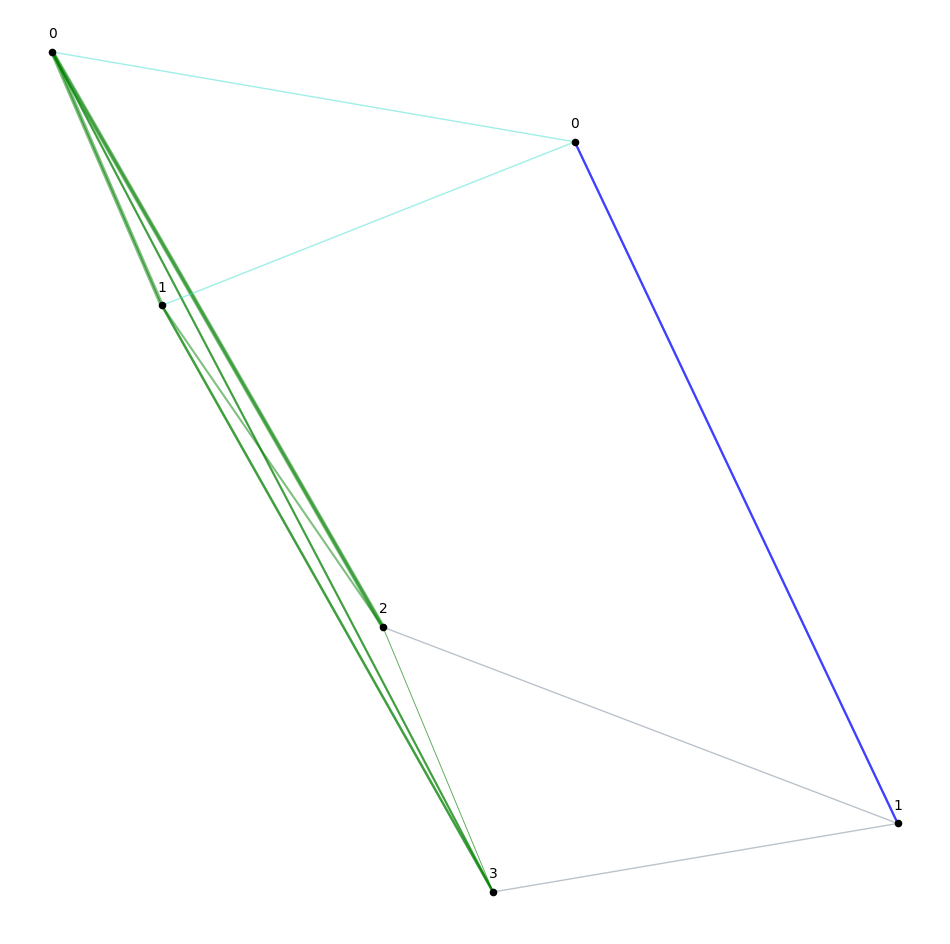

In [3]:
# Function to plot a graph using its adjacency matrix and vertex coordinates
def plot_graph(A, V, ax, color, title):
    # Plot edges
    scale_A = 4*((A - np.min(A)) / np.max(A))
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            weight = scale_A[i, j]
            if weight > 0:
                ax.plot([V[i, 0], V[j, 0]], [V[i, 1], V[j, 1]], color=color, lw=weight, alpha=0.5)
    
    # Plot vertices
    ax.scatter(V[:, 0], V[:, 1], c='black', s=20, zorder=5)
    
    # Annotate vertices
    for i, txt in enumerate(range(V.shape[0])):
        ax.annotate(txt, (V[i, 0], V[i, 1]), textcoords="offset points", xytext=(0, 10), ha='center')
    
    ax.set_title(title)

# Create a plot
# fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# # Plot the two graphs
# plot_graph(A1, V1, ax[0], 'Graph 1')
# plot_graph(A2, V2, ax[1], 'Graph 2')

# plt.show()

# Function to plot graph alignment using otc_alignment matrix
def plot_graph_alignment(A1, V1, A2, V2, otc_alignment, ax):
    # Plot the original graphs first
    
    graph_drift = [np.max(np.max(V1, axis=0))*2, 0]
    
    plot_graph(A1, V1, ax, 'green', 'Graph 1 and Graph 2 with Edge Alignment')
    plot_graph(A2, V2 + graph_drift, ax, 'blue', '')  # Offset the second graph for better visualization
    
    # Find non-zero entries in the otc_alignment matrix
    alignment_indices = np.argwhere(otc_alignment > 0.)
    color_choice = random.sample(all_color, V2.shape[0])
        
    # Draw alignment edges
    for i, j in alignment_indices:
        # Determine the corresponding vertices in V1 and V2
        v1_idx = i % A1.shape[0]
        v2_idx = j % A2.shape[0]

        # Draw an edge between the corresponding vertices in V1 and V2
        v1_coord = V1[v1_idx, :]
        v2_coord = V2[v2_idx, :] + graph_drift  # Offset the second graph's coordinates
        ax.plot([v1_coord[0], v2_coord[0]], [v1_coord[1], v2_coord[1]], color=color_choice[v2_idx], lw=1, alpha=0.5)
    # ax.set_aspect('equal')
    ax.axis('off')

# Create a new plot
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the graph alignment
plot_graph_alignment(A1, V1, A2, V2, otc_alignment, ax)

plt.show()
